## Goal: Build a ReAct Agent

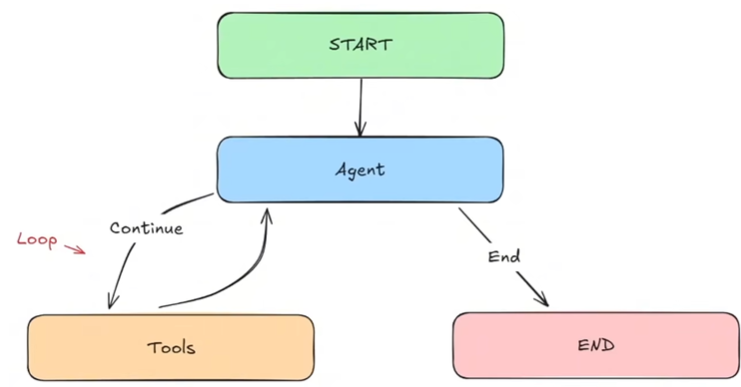

1️⃣ The ReAct Loop

Here’s the high-level cycle a ReAct agent follows:
- Observe the input (e.g., a user question).
- Reason — generate a thought describing what to do next.
- Act — execute a tool or function (e.g., calculator, search, database query).
- Observe the result.
- Repeat until the goal is achieved.

LangGraph takes this a step further — instead of an implicit loop inside initialize_agent, you explicitly build the reasoning–acting loop as a graph of nodes:
- LLM node: does reasoning and decides next action.
- ToolNode: executes the chosen tool (action).
- Conditional edges check whether to continue or stop (should_continue).

**LangGraph executes your graph as a generator** — it doesn’t always wait until the entire flow finishes.
Instead, it streams intermediate state updates node by node (or message by message).
That’s what this part does:

`app.stream(input=inputs, stream_mode="values")`

It means:
“Run my compiled LangGraph app, and stream each intermediate value of the state as the graph executes.”
So instead of getting a single final output, you get an iterator — a stream of states.

`message = s["messages"][-1]` : Each state has a list of messages (s["messages"]).
[-1] means "the most recent message" — the last thing that happened in the conversation (could be a tool call, a tool response, or the AI’s reply).

LangGraph:

Runs the graph asynchronously, node by node.
Each time a node finishes (for example, LLM node, then ToolNode, then next LLM), it yields a partial state.
The generator (stream) gives you those partial snapshots.
You can consume them one by one like:
    for state in app.stream(input=inputs, stream_mode="values"):
        print(state)
    But since the state dict can be huge, we usually just inspect state["messages"][-1] — the newest message added so far — and print it.


#### imports

In [23]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

from IPython.display import Image, display

import os
from dotenv import load_dotenv

In [24]:
import pkg_resources
print(pkg_resources.get_distribution("langgraph").version)

0.6.8


In [25]:
load_dotenv()

True

#### AgentState

- 👉 `add_messages`: Whenever a new message is added to the state, don’t overwrite "messages". Instead, append it to the existing list.
- 👉 `Sequence`: Type hint: "messages" is a sequence (list, tuple, etc.) of `BaseMessage` objects.
- 👉 `BaseMessage`: can be `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`

In [26]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Define tools

In [27]:
@tool
def add(a:int, b:int):
    """ This is an addition function that adds two numbers"""
    return a + b

@tool
def sub(a:int, b:int):
    """ This is a subtraction function that subtracts two numbers"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """This is a multiplication function that multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [28]:
tools = [add, sub, multiply]

#### Define Model

In [29]:
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [30]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability.")
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [31]:
'''
'tool_calls': 
[{'id': 'call_yZ97kMZuNXrgpn7w1jOJwjRW', 
  'function': {'arguments': 
							'{"a":40,"b":12}', 
							'name': 'add'}, 
							'type': 'function'
			  }
]
'''
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1] ## Extracting the last AIMessage
    if not last_message.tool_calls:  
        return "end"
    else:
        return "continue"    

#### Memory into Graph

In [32]:
memory_saver = MemorySaver()

In [33]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

#### Building Graph

In [34]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("our_agent")
graph.add_conditional_edges("our_agent",
                            should_continue,
                            {
                                "continue": "tools",
                                "end": END
                            })
graph.add_edge("tools", "our_agent")
app = graph.compile(checkpointer=memory_saver)

#### Graph Visualization

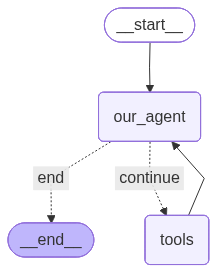

In [35]:
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
'''
param: stream is an iterator returned by app.stream(). 
So stream is not a list — it’s something you can iterate over (like reading a file line-by-line).
'''
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

#### Giving human input

In [37]:
'''
[("user", "Add 40 + 12")]

This means:
It’s a list with one message (the user’s message).
Each message tuple has two parts:
    The role — "user" (or "system", "assistant", "tool", etc.)
    The content — the text of the message ("Add 40 + 12")
'''
inputs = {"messages" : [("user", "Add 40 + 12")]}

In [38]:
print_stream(app.stream(input=inputs, stream_mode="values", config=config))

================================ Human Message =================================

Add 40 + 12
================================== Ai Message ==================================
Tool Calls:
  add (call_Gk6hPtf0DMDEkTpxWkaqT6WB)
 Call ID: call_Gk6hPtf0DMDEkTpxWkaqT6WB
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

The result of adding 40 and 12 is 52.


In [39]:
inputs2 = {"messages" : [("user", "Multiply that by 2.")]}
print_stream(app.stream(input=inputs2, stream_mode="values", config=config))

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CHX7M16XGAdPqSRxoQtsPKJx)
 Call ID: call_CHX7M16XGAdPqSRxoQtsPKJx
  Args:
    a: 52
    b: 2
================================= Tool Message =================================
Name: multiply

104
================================== Ai Message ==================================

Multiplying 52 by 2 gives you 104.


**Note**: `For above to work, we have to enble checkpointing. In order for checkpointing to work we have to either pass checkpoint_id or thread_id`